import statement

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import os
import time
import json
import random
import numpy as np

from PIL import  Image

In [3]:
devices = tf.config.experimental.list_physical_devices("GPU")
print(devices)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


getting data ready

In [4]:
data_dir = r'/content/drive/MyDrive/flickr8k'
# image_dir = f'{data_dir}/Images'
txt_file = f'{data_dir}/captions.txt'
# store_features = '/content/features'

Deleting any previous .npy file


In [6]:
# full_image_dir = []
s0_comment_s1 = []

with open(txt_file,'r') as file:
  content = file.readlines()
  content = content[1:]
  for line in content:
    result = line.split(',')
    # image_name = result[0]
    raw_comment = result[1]
    # single_image_full_dir = os.path.join(image_dir,image_name)

    single_comment = f'<start> {raw_comment} <end>'
    single_comment = single_comment.replace("\n","").replace(".","")
    s0_comment_s1.append(single_comment)
train_captions = s0_comment_s1


cutting the datatset

In [7]:
train_captions[:20]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>',
 '<start> A black dog and a spotted dog are fighting <end>',
 '<start> A black dog and a tri-colored dog playing with each other on the road  <end>',
 '<start> A black dog and a white dog with brown spots are staring at each other in the street  <end>',
 '<start> Two dogs of different breeds looking at each other on the road  <end>',
 '<start> Two dogs on pavement moving toward each other  <end>',
 '<start> A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl  <end>',
 '<start> A little girl is sitting in front of a large painted rainbow  <end>',
 '<start> A small girl in the grass plays with finger

Mapping each image to their 5 captions through dict

Preparing the data for training

In [20]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,(299,299))
    image= tf.keras.applications.inception_v3.preprocess_input(image)
    return image,image_path


Loading the Inception V3 Model

In [22]:
image_model = tf.keras.applications.InceptionV3(include_top = False,weights = 'imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

In [23]:
print(image_model.layers[-1].output)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'")


Create Dataset Pipeline using tensorflow dataset

In [29]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

captions preprocessing

In [30]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token = "<unk>",
                                                  filters = '!#$%&()*+_,-/:;-=?@[\]^_*{|}~')
tokenizer.fit_on_texts(train_captions)


In [31]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
print(tokenizer.word_index['<pad>'])
print(tokenizer.index_word[0])

0
<pad>


In [47]:
batch_size = 16
buffer_size =500
embedding_dim = 350
units = 522
vocab_size =  top_k+1
# num_steps = len(img_name_train)
features_shape = 2048
attention_features_shape = 64

Bahdanau Attention

In [54]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self,units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

        # these above three will calculate alignment scor(e<t,t`>)
    def call(self,features,hidden):
        hidden_with_time_axis = tf.expand_dims(hidden,1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score,axis = 1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector,axis = 1)
        return context_vector,attention_weights
    def intuition(self):
        '''
        feature shape is (m,64,2048)
        hidden shape is (m,n_s)
        n_s means number of hidden units in the decoder rnn
        '''

        tst_features_shape = (2, 64, 2048)  # batch_size=2, sequence_length=5, feature_dim=10
        tst_hidden_with_time_axis_shape = (2, 1, 15)  # batch_size=2, 1 time step, hidden_dim=15

        # Creating imaginary tensors with shapes
        tst_features = tf.random.normal(tst_features_shape)
        tst_hidden_with_time_axis = tf.random.normal(tst_hidden_with_time_axis_shape)

        # Calculating attention_hidden_layer
        tst_out1 = self.W1(tst_features)
        tst_out2 = self.W2(tst_hidden_with_time_axis)
        tst_attention_hidden_layer = tf.nn.tanh(tst_out1 + tst_out2)
        tst_score = self.V(tst_attention_hidden_layer)
        tst_attention_weights = tf.nn.softmax(tst_score,axis = 1)
        tst_context_vector = tst_attention_weights * tst_features
        tst_final_context_vector = tf.reduce_sum(tst_context_vector,axis = 1)
        print(tst_out1.shape)
        print(tst_out2.shape)
        print(tst_attention_hidden_layer.shape)
        print(tst_score.shape)
        print(tst_context_vector.shape)
        print(tst_final_context_vector.shape)

# op0 = BahdanauAttention(3)
# op0.intuition()

In [55]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self,embedding_dim):
        super().__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self,x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    def intuition(self):

        '''
        x is a image tensor of m trainable example depending on batch size
        x shape is (m,64,2048)
        '''
        tst_img_tensor_shape = (2,64,2048)
        tst_img_tensor = tf.random.normal(tst_img_tensor_shape)

        tst_x = self.fc(tst_img_tensor)
        print(tst_x.shape)


op1 = CNN_Encoder(3)
op1.intuition()





(2, 64, 3)


In [56]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self,embedding_dim,units,vocab_size):
        super().__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences = True,
                                       return_state = True,
                                       recurrent_initializer = 'glorot_uniform'
                                         )
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self,x,features,hidden):
        ### x shape is (m,1) here it is (16,1)
        ### features shape is (m,64,250) here is (16,64,250)
        ### hidden shape is (m,n_s) here is (16,522)

        context_vector,attention_weights = self.attention(features,hidden)
        ### context vector shape is (16,250)
        ### attention_weights shape is (16,64,1)

        # print(f'context vetcor shape is {context_vector.shape}')
        # print(context_vector.shape)
        # print(attention_weights.shape)

        x = self.embedding(x)
        ### now x shape is (m,1,emb_dim) here is (16,1,250)

        # print(f'shape after embedding {x.shape}')
        x = tf.concat([tf.expand_dims(context_vector,1),x],axis = -1)
        ### now x shape is (m,1,500) and here is (16,1,500)
        # print(f'shape after concatenation is {x.shape}')


        output, state = self.gru(x)
        ## output represent hidden sate at each time step t
        ## state represent hidden state at final time step t
        ### output shape is (16,1,522)
        ### state shape is (16,522)



        # print(output.shape)
        # print(state.shape)

        x = self.fc1(output)
        ### x shape is (16,1,522)


        x = tf.reshape(x,(-1,x.shape[2]))
        ### x shape is (16,522)

        x = self.fc2(x)
        ### x shape is (16,5001)


        return x,state, attention_weights
    def reset_sates(self,batch_size):
        return tf.zeros((batch_size,self.units))
    # def intuition(self):
    #     tst_x_shape = (16,1)
    #     tst_x = tf.random.normal(tst_x_shape)
    #     tst_x = self.embedding(tst_x)
    #     print(tst_x.shape)



In [57]:
encoder = CNN_Encoder(embedding_dim)
decoder =  RNN_Decoder(embedding_dim,units,vocab_size)

In [58]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction="none")


def loss_function(real,pred):
   mask = tf.math.logical_not(tf.math.equal(real,0))
   # print(mask)
   loss_ = loss_object(real,pred)
   mask = tf.cast(mask,dtype=loss_.dtype)
   loss_ *= mask
   return tf.reduce_mean(loss_)

In [59]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=5)

In [60]:
start_epoch = 1
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [64]:
max_length = 35

In [65]:
def evaluate(image):
    attention_plot = np.zeros((max_length,attention_features_shape))

    hidden = decoder.reset_sates(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0],0)

    img_tensor_val = image_features_extract_model(temp_input)

    img_tensor_val = tf.reshape(img_tensor_val,(img_tensor_val.shape[0],-1,img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)


    dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
    # print(f'dec_input {dec_input.shape}')
    result = []


    ### in these code previous time step predicted input is feeded through dec_input
    for i in range(max_length):
        predictions,hidden,attention_weights = decoder(dec_input,features,hidden)
        # print(f'attention weight {attention_weights.shape}')
        # print(f'attention plot {attention_plot.shape}')
        attention_plot[i] = tf.reshape(attention_weights,(-1,)).numpy()
        # print(f' new attent { attention_plot[i].shape}')
        predicted_id = tf.argmax(predictions[0]).numpy()
        # print(f'id {predicted_id}')

        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result,attention_plot
        dec_input = tf.expand_dims([predicted_id],0)
    attention_plot = attention_plot[:len(result),:]
    # print(result)
    return result, attention_plot


In [66]:
def plot_attention(image,result,attention_plot):
    print('i am in func')
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize= (30,30))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i],(8,8))
        grid_size = max(int(np.ceil(len_result/2)),2)
        ax = fig.add_subplot(grid_size,grid_size,i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att,cmap = 'gray',alpha = 0.6,extent = img.get_extent())
    plt.tight_layout()
    plt.show()

Prediction Caption: a man guitar his right <end>
i am in func


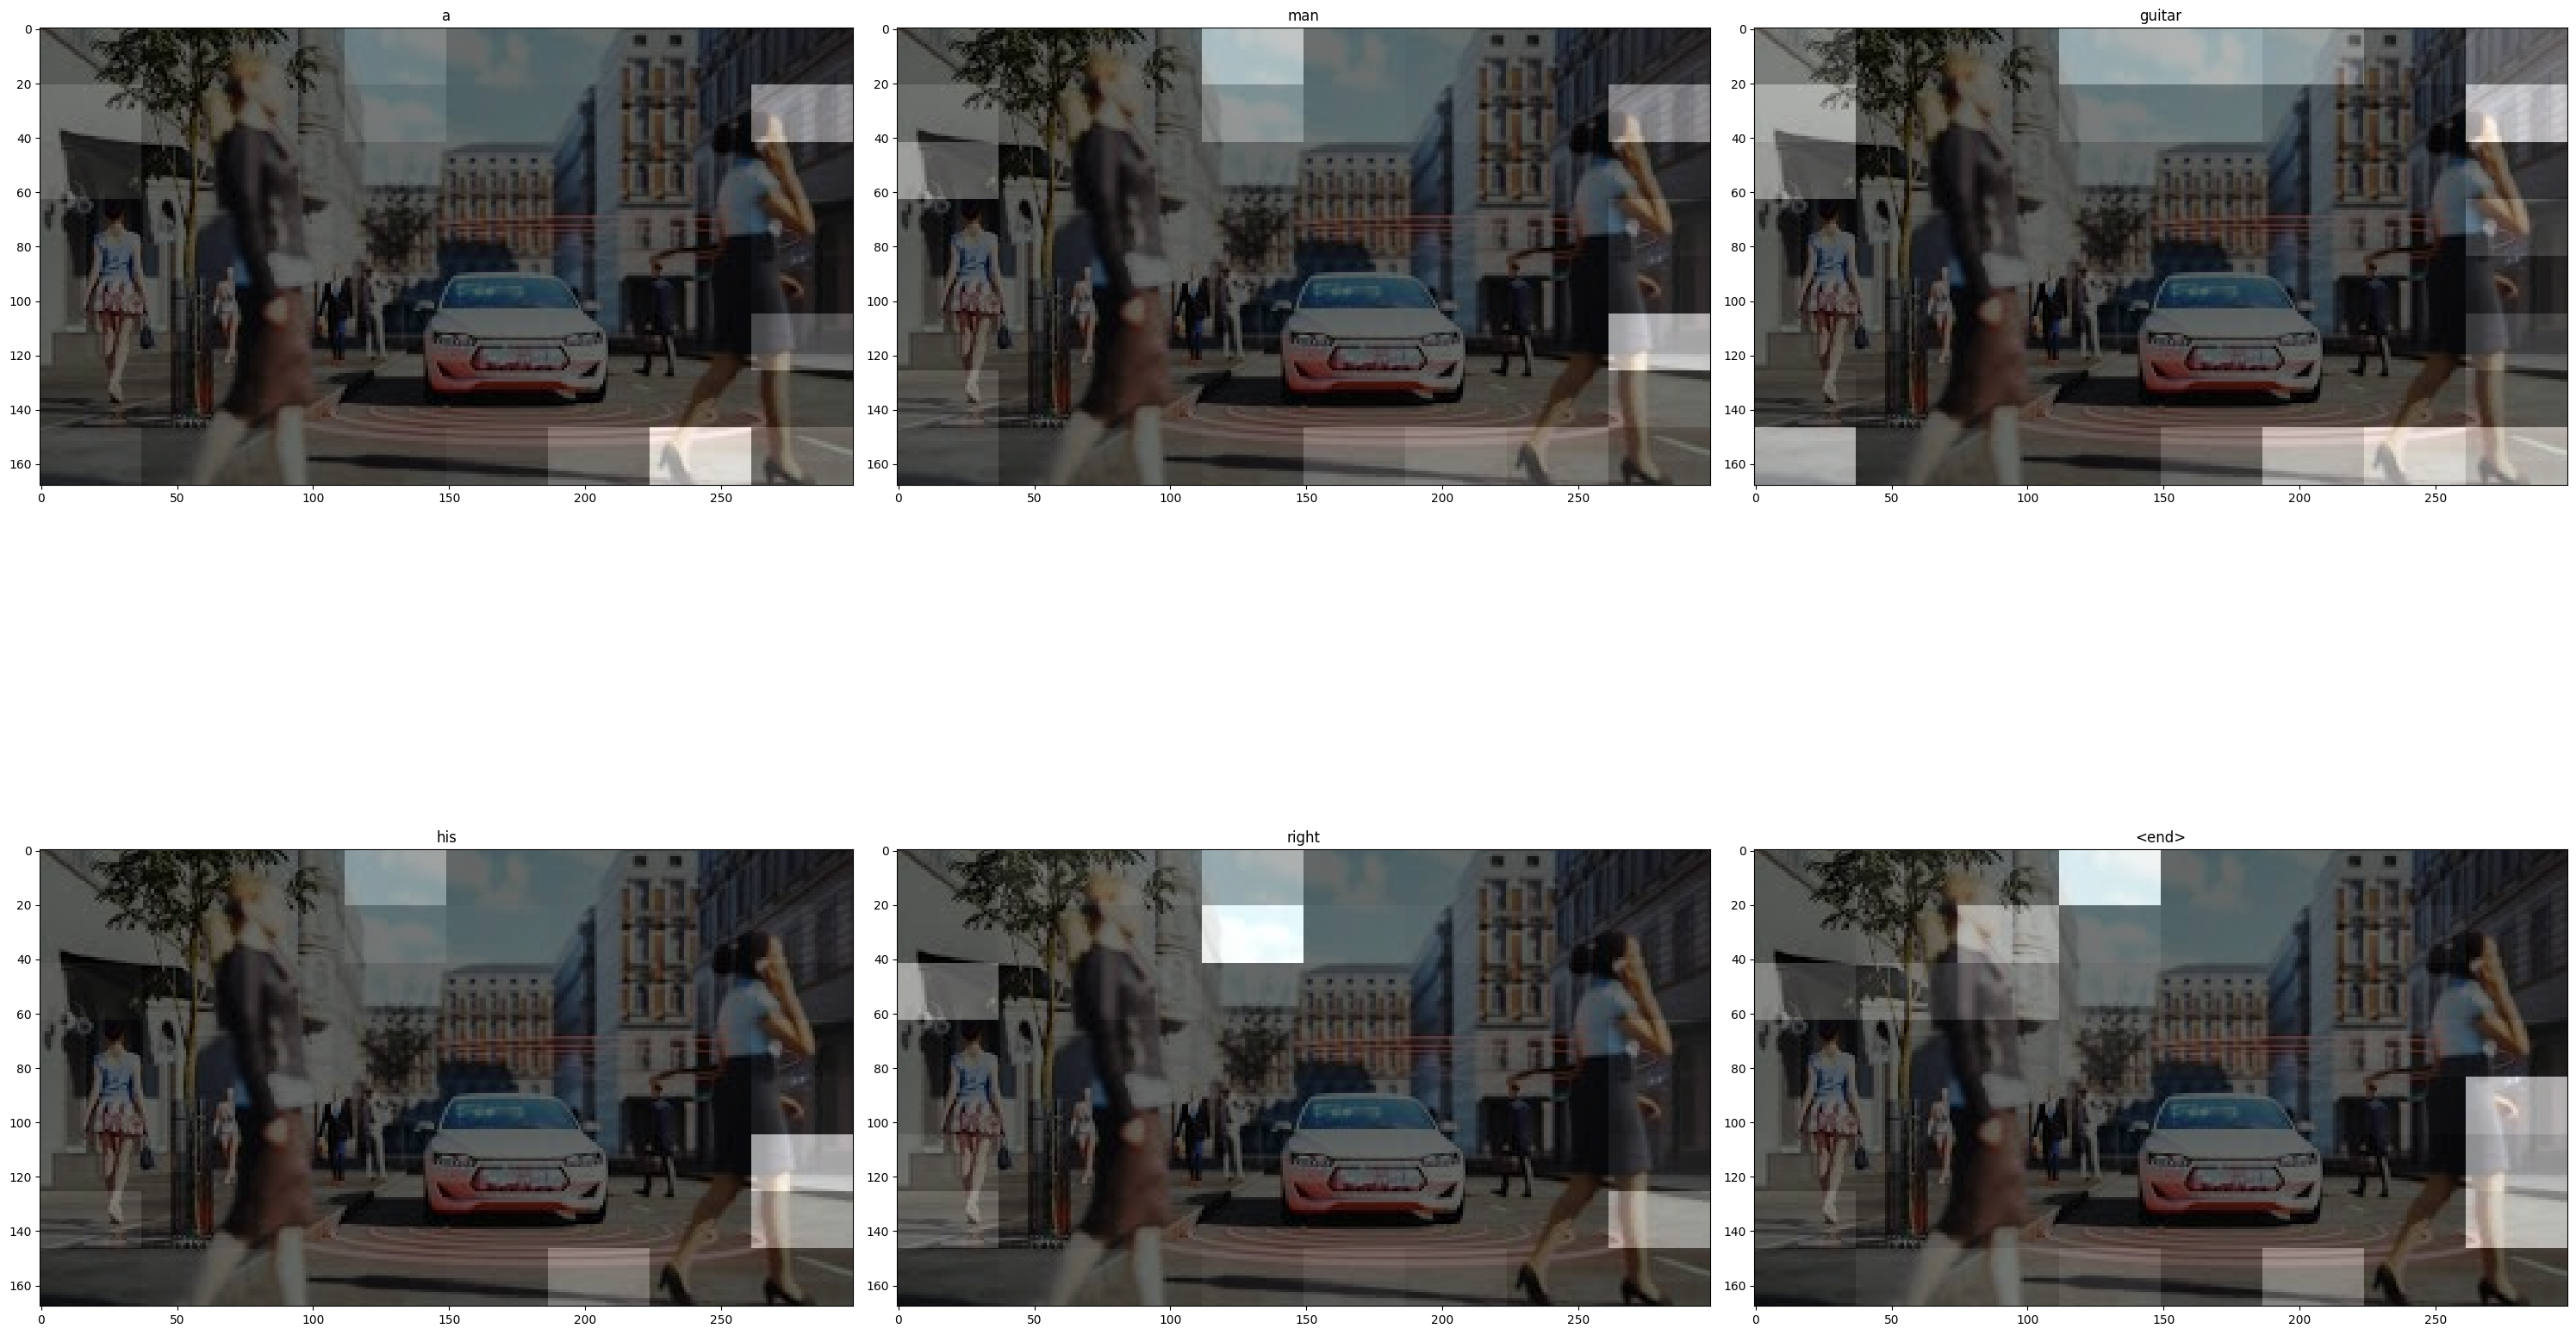

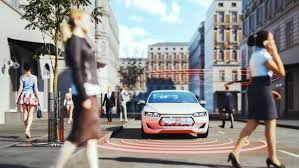

In [70]:
# rid = np.random.randint(0,len(img_name_val))
test_image = '/content/imagesfolder/check1.jpg'
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result,attention_plot = evaluate(test_image)
# print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(test_image,result,attention_plot)

Image.open(test_image)